# Lectura de datos crudos y tratamiento

## Importar librerías

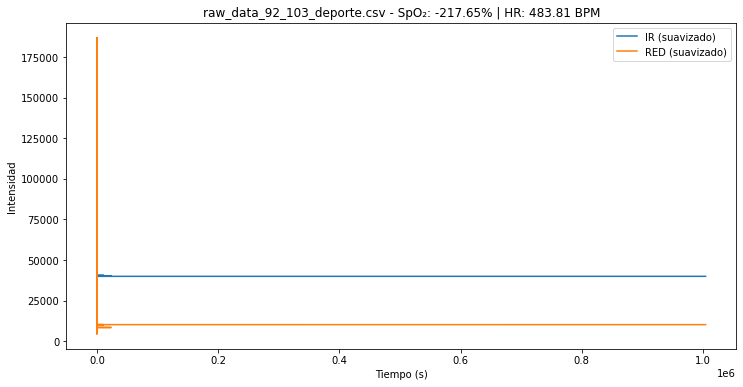

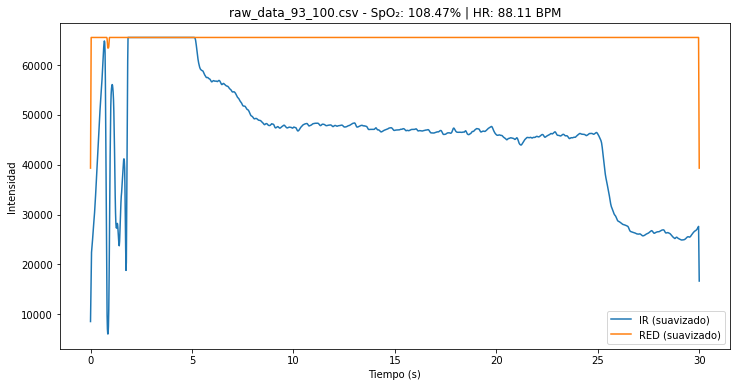

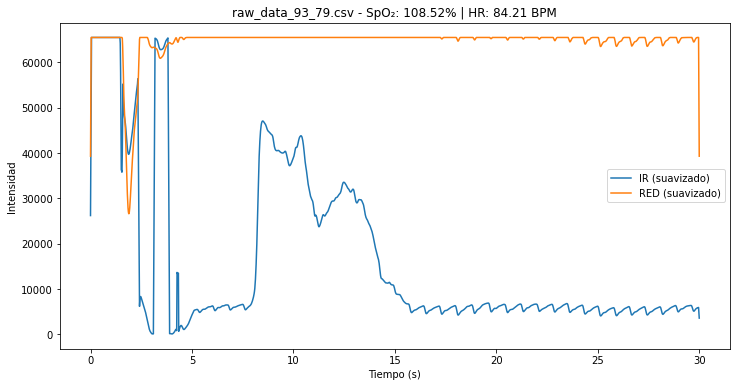

Formato incorrecto en: raw_data_95_77.csv


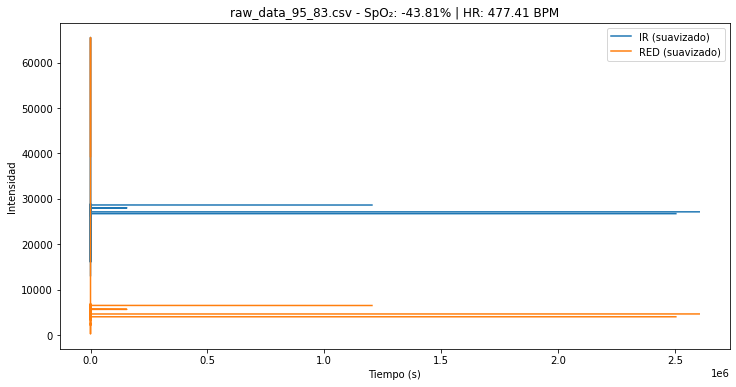

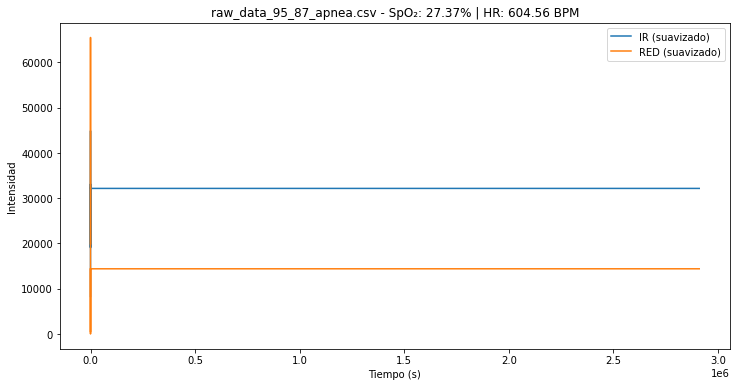

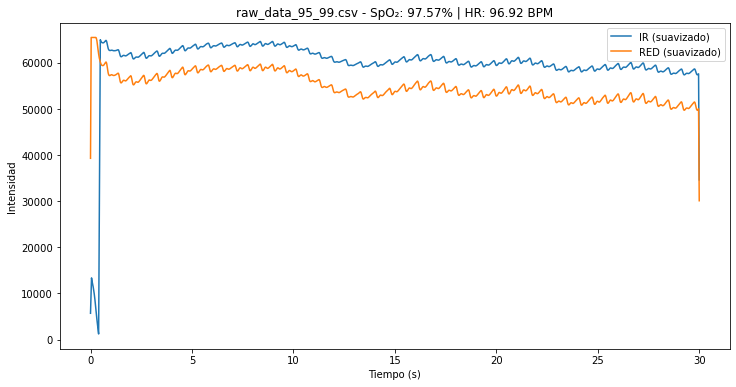

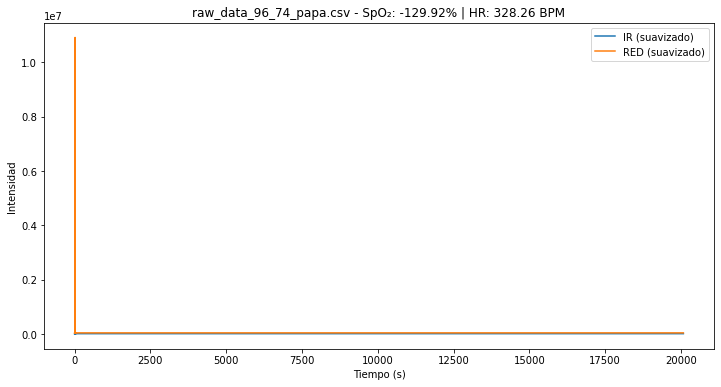

                       Archivo  SpO₂ real  HR real  SpO₂ calculado  \
0  raw_data_92_103_deporte.csv         92      103         -217.65   
1          raw_data_93_100.csv         93      100          108.47   
2           raw_data_93_79.csv         93       79          108.52   
3           raw_data_95_83.csv         95       83          -43.81   
4     raw_data_95_87_apnea.csv         95       87           27.37   
5           raw_data_95_99.csv         95       99           97.57   
6      raw_data_96_74_papa.csv         96       74         -129.92   

   HR calculado  Error SpO₂  Error HR  
0        483.81      309.65    380.81  
1         88.11       15.47     11.89  
2         84.21       15.52      5.21  
3        477.41      138.81    394.41  
4        604.56       67.63    517.56  
5         96.92        2.57      2.08  
6        328.26      225.92    254.26  
¡Análisis completado! Los resultados se han guardado en 'resultados_estimaciones.csv'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from scipy.signal import find_peaks

# Ruta donde tienes los archivos CSV
ruta_datos = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Función para calcular SpO2
def calcular_spo2(ir, red):
    ac_ir = np.std(ir)    # Componente AC (desviación estándar)
    dc_ir = np.mean(ir)   # Componente DC (media)
    ac_red = np.std(red)
    dc_red = np.mean(red)

    # Calcular el coeficiente R
    R = (ac_red / dc_red) / (ac_ir / dc_ir)

    # Fórmula empírica
    spo2 = 110 - 25 * R
    return spo2

# Función para calcular la frecuencia cardíaca (HR)
def calcular_hr(senal, tiempo):
    # Detectar picos en la señal IR (ajustar 'height' y 'distance' si es necesario)
    picos, _ = find_peaks(senal, height=1000, distance=20)

    # Calcular el tiempo entre picos (en segundos)
    tiempos_picos = tiempo[picos]
    intervalos = np.diff(tiempos_picos)

    # Calcular HR (latidos por minuto)
    if len(intervalos) > 0:
        hr = 60 / np.mean(intervalos)
        return hr
    else:
        return np.nan

# Función para suavizar las señales (filtro de media móvil)
def suavizar(senal, ventana=5):
    return np.convolve(senal, np.ones(ventana) / ventana, mode='same')

# Listar los archivos CSV en la carpeta
archivos = [f for f in os.listdir(ruta_datos) if f.endswith('.csv')]

# Almacenar resultados
resultados = []

# Procesar cada archivo CSV
for archivo in archivos:
    # Extraer SpO₂ y HR reales del nombre del archivo (ejemplo: raw_data_93_100.csv)
    valores = re.findall(r'\d+', archivo)
    if len(valores) >= 2:
        spo2_real, hr_real = map(int, valores[-2:])
    else:
        print(f"No se pudieron extraer los valores del archivo: {archivo}")
        continue

    # Ruta completa del archivo
    ruta_completa = os.path.join(ruta_datos, archivo)

    # Cargar el CSV
    df = pd.read_csv(ruta_completa)

    # Validar que el CSV tenga las columnas correctas
    if not all(col in df.columns for col in ["Tiempo (ms)", "IR", "RED"]):
        print(f"Formato incorrecto en: {archivo}")
        continue

    # Convertir tiempo a segundos
    df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000

    # Suavizar las señales
    df["IR_suave"] = suavizar(df["IR"])
    df["RED_suave"] = suavizar(df["RED"])

    # Calcular HR y SpO2
    hr_calculado = calcular_hr(df["IR_suave"].values, df["Tiempo (s)"].values)
    spo2_calculado = calcular_spo2(df["IR_suave"], df["RED_suave"])

    # Calcular errores
    error_spo2 = abs(spo2_calculado - spo2_real)
    error_hr = abs(hr_calculado - hr_real)

    # Guardar los resultados
    resultados.append({
        "Archivo": archivo,
        "SpO₂ real": spo2_real,
        "HR real": hr_real,
        "SpO₂ calculado": round(spo2_calculado, 2),
        "HR calculado": round(hr_calculado, 2),
        "Error SpO₂": round(error_spo2, 2),
        "Error HR": round(error_hr, 2)
    })

    # Visualizar las señales
    plt.figure(figsize=(12, 6))
    plt.plot(df["Tiempo (s)"], df["IR_suave"], label="IR (suavizado)")
    plt.plot(df["Tiempo (s)"], df["RED_suave"], label="RED (suavizado)")
    plt.title(f"{archivo} - SpO₂: {spo2_calculado:.2f}% | HR: {hr_calculado:.2f} BPM")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Intensidad")
    plt.legend()
    plt.show()

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla resumen
print(df_resultados)

# Guardar los resultados en un CSV
df_resultados.to_csv(r"C:\Users\Elena\Desktop\resultados_estimaciones.csv", index=False)

print("¡Análisis completado! Los resultados se han guardado en 'resultados_estimaciones.csv'")
